In [28]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from keras import backend as K

from datasets import Dataset
import losses
import cnns
from models import Model
from regression import RegressionLayer
from cropping import align, detect_landmarks, crop_feature, crop_face, draw_boxes

import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import saliency.core as saliency
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib

In [19]:
names = [
    "nose",
    "lips",
    "eyes",
    "cheeks",
    "chin",
    "eyebrows",
]

dataset = "SCUT-FBP5500"
output_size = 5

In [20]:
resnets = []
for name in names:
    cnn = cnns.ResNet50(weights="vggface")
    cnn.construct()
    resnet = Model(
        cnn, 
        parent_name=dataset,
        name=name, 
        loss="categorical_crossentropy", 
        output_size=output_size,
        load_weights=True
    )
    resnet.construct(activation="softmax")
    resnets.append(resnet)

In [21]:
cnn = cnns.ResNet50(weights="vggface")
cnn.construct()
vggface = Model(
    cnn, 
    parent_name=dataset,
    name="mediapipe", 
    loss="categorical_crossentropy", 
    output_size=output_size,
    load_weights=True
)
vggface.construct(activation="softmax")

In [15]:
df = pd.read_csv(f"{dataset}/distribution.csv")

In [16]:
def call_model_function(images, call_model_args=None, expected_keys=None):
    with tf.GradientTape() as tape:
        x = tf.convert_to_tensor(images)
        tape.watch(x)
        result = vggface.full_model(x)
        grads = tape.gradient(result, x)
    return {saliency.INPUT_OUTPUT_GRADIENTS: grads}

In [8]:
file = "AF8.jpg"

In [22]:
x = np.zeros((5,len(resnets)))
for i in range(len(resnets)):
    x[...,i] = resnets[i].inference(os.path.join(dataset,"mediapipe",file))

means = x.T@np.arange(1,6)
means = np.append(
    means, 
    df[df["filename"] == file]["mean"].to_numpy()
)
means = np.round(means,2)
names2 = names + ["true score"]
names2 = np.array([name.replace("_", " ") for name in names2])

In [10]:
image = align(os.path.join(dataset,"images",file))
m1, m2 = crop_face(image)
image_resized = cv2.resize(
    image[m1[1]:m2[1],m1[0]:m2[0]], 
    (224,224), 
    interpolation=cv2.INTER_LANCZOS4
)[...,::-1]

xrai_object = saliency.XRAI()
xrai_attributions = xrai_object.GetMask(
    vggface.preprocess(image_resized), 
    call_model_function, 
    None, 
    batch_size=20
)

mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
masked_image = image_resized.copy()
masked_image[~mask] = 0

In [23]:
def transform_coordinates(p1, p2, m1, m2):
    sf = 224/(m2-m1)
    m = np.max(m2-m1)
    p1 = np.clip(p1-m1, a_min=0, a_max=m)
    p2 = np.clip(p2-m1, a_min=0, a_max=m)
    p1 = np.clip(np.uint8(p1*sf), a_min=0, a_max=224)
    p2 = np.clip(np.uint8(p2*sf), a_min=0, a_max=224)

    return p1, p2

In [24]:
scores = np.zeros(len(names))
_, detection_result = detect_landmarks(image=image)

for i in range(len(names)):
    normalised = (xrai_attributions - np.min(xrai_attributions)) / (np.max(xrai_attributions) - np.min(xrai_attributions))
    s1 = np.sum(normalised)
    n1 = len(normalised.flatten())

    if names[i] == "cheeks":
        _, p1, p2 = crop_feature("left_cheek", image, detection_result)
        _, q1, q2 = crop_feature("right_cheek", image, detection_result)
        p1, p2 = transform_coordinates(p1, p2, m1, m2)
        q1, q2 = transform_coordinates(q1, q2, m1, m2)

        s2 = np.sum(normalised[p1[1]:p2[1],p1[0]:p2[0]])
        s3 = np.sum(normalised[q1[1]:q2[1],q1[0]:q2[0]])
        n2 = len(normalised[p1[1]:p2[1],p1[0]:p2[0]].flatten())
        n3 = len(normalised[q1[1]:q2[1],q1[0]:q2[0]].flatten())
        u1 = (s1-(s2+s3))/(n1-(n2+n3))
        u2 = (s2+s3)/(n2+n3)

    else:
        _, p1, p2 = crop_feature(names[i], image, detection_result)
        p1, p2 = transform_coordinates(p1, p2, m1, m2)
        s2 = np.sum(normalised[p1[1]:p2[1],p1[0]:p2[0]])
        n2 = len(normalised[p1[1]:p2[1],p1[0]:p2[0]].flatten())
        u1 = (s1-s2)/(n1-n2)
        u2 = s2/n2

    scores[i] = (u2-u1)/u1
scores = np.round(scores, 3)

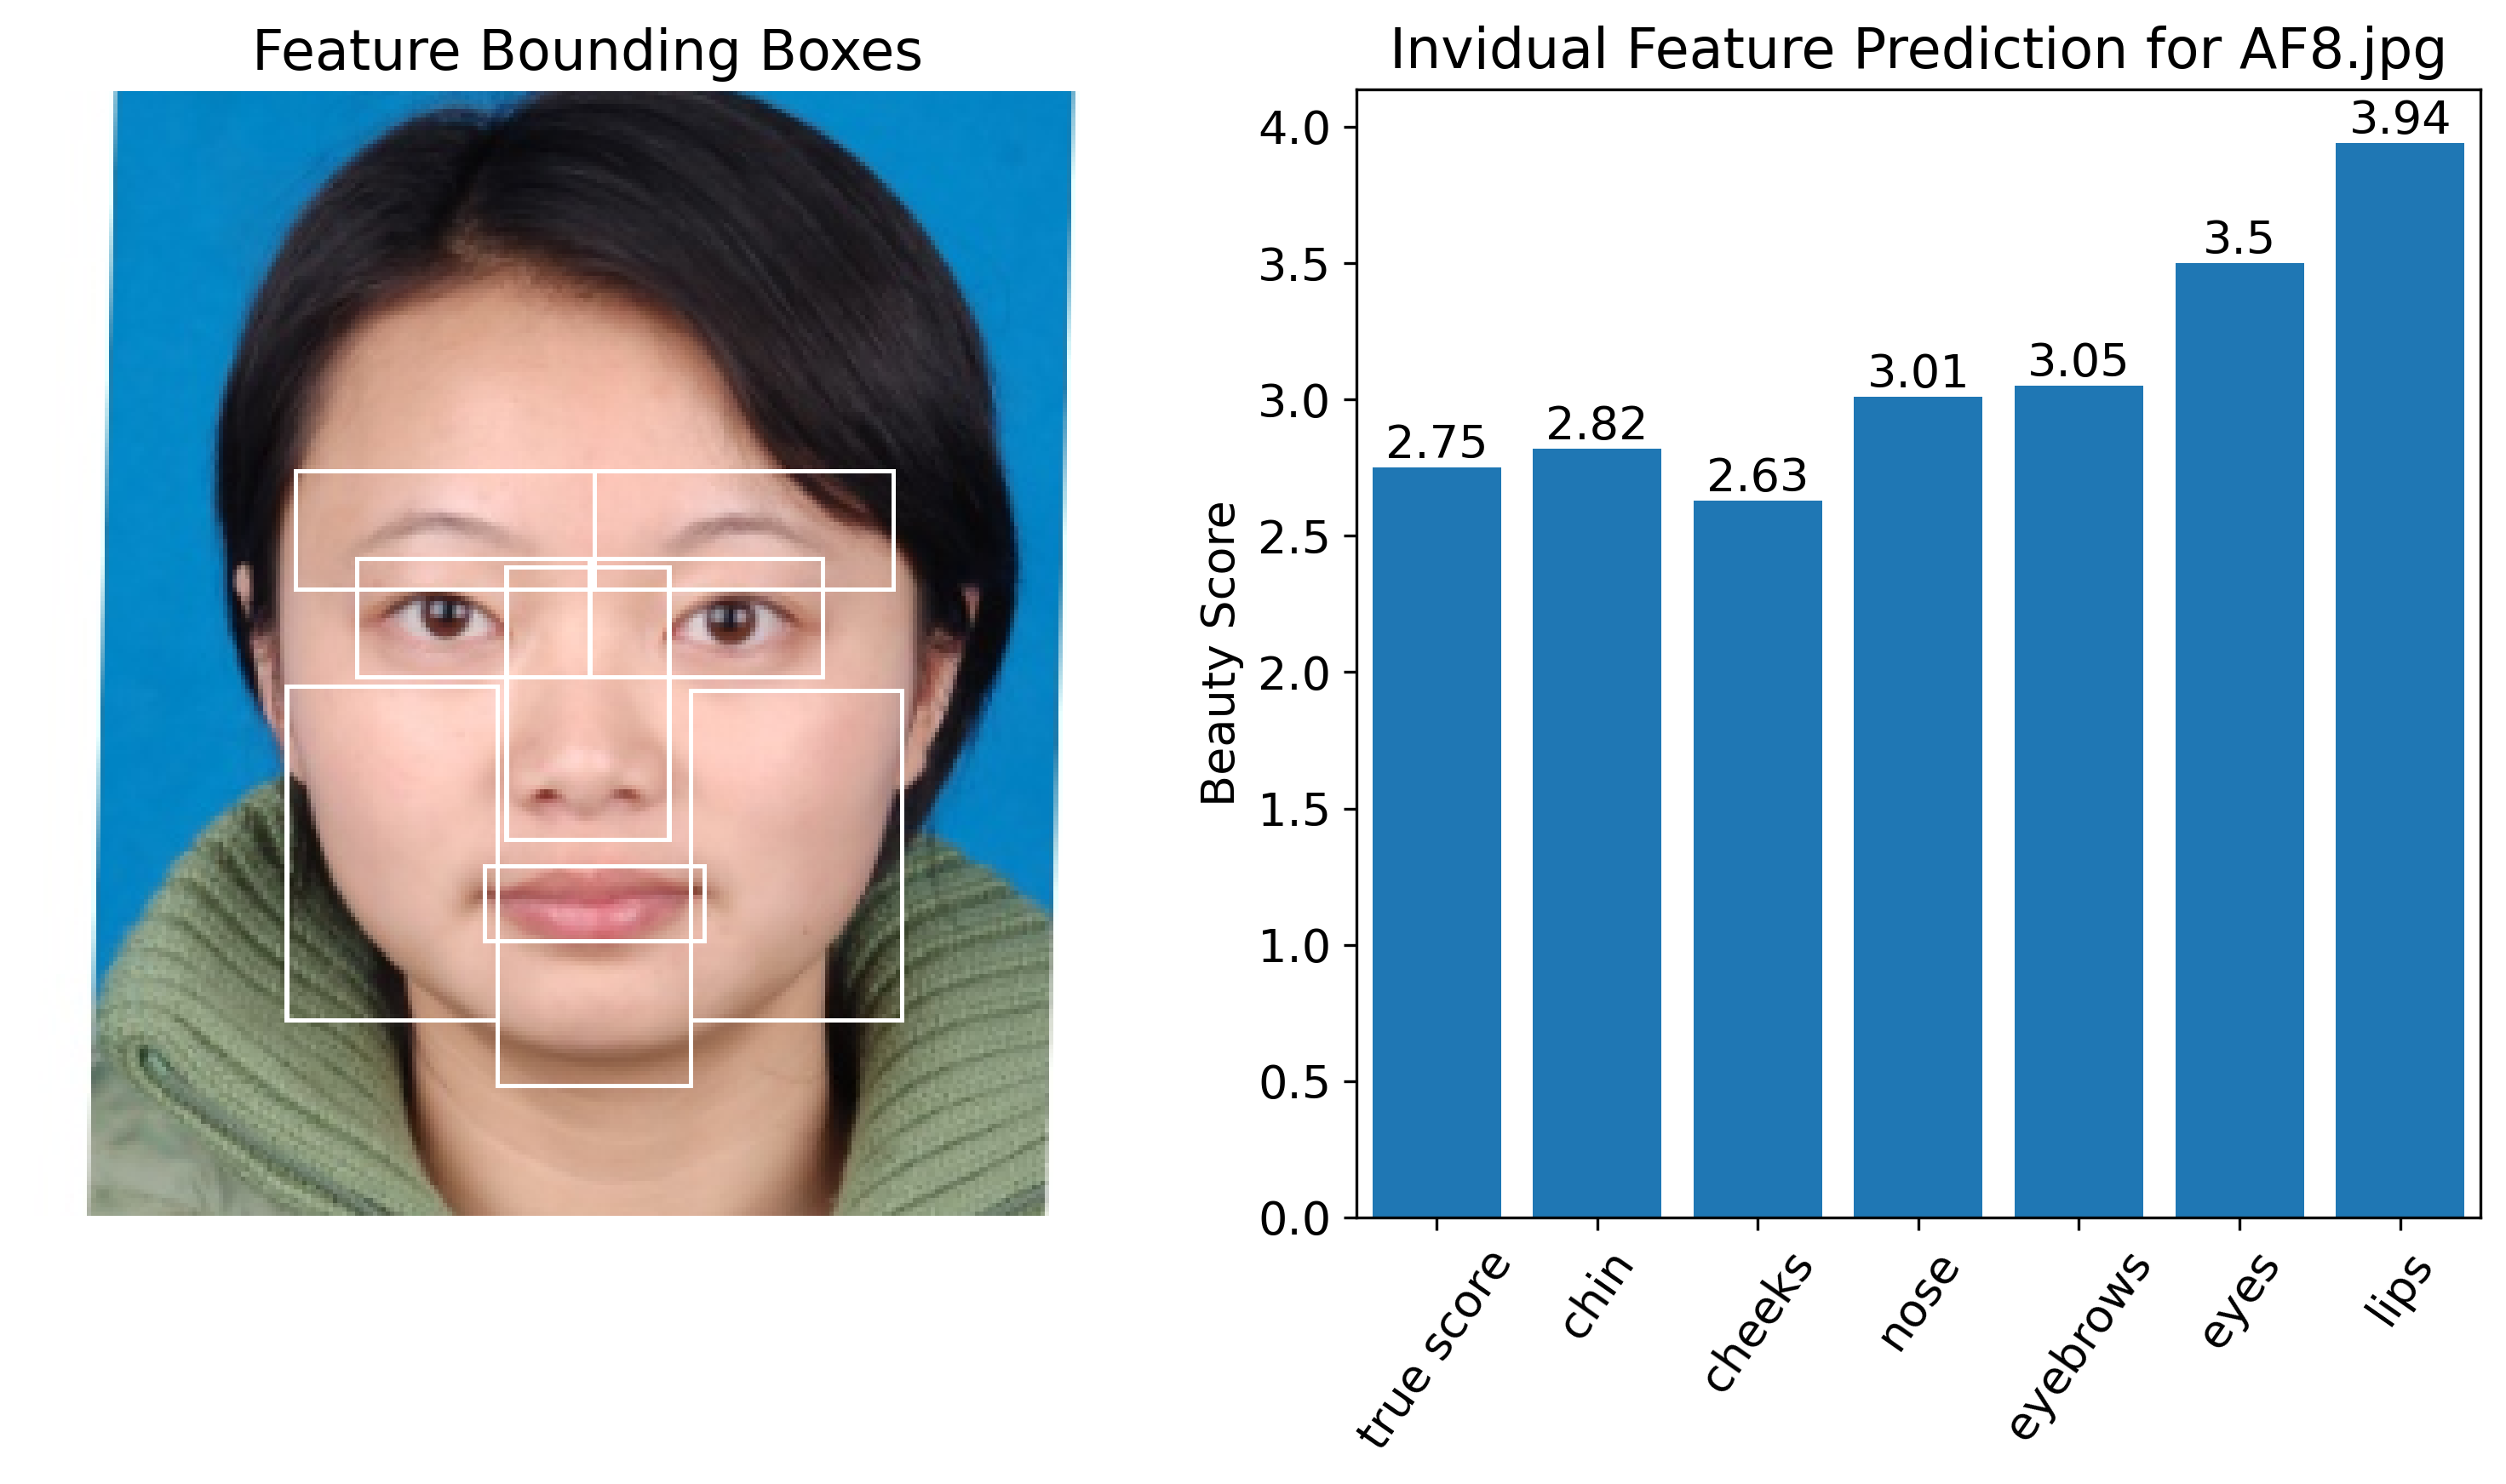

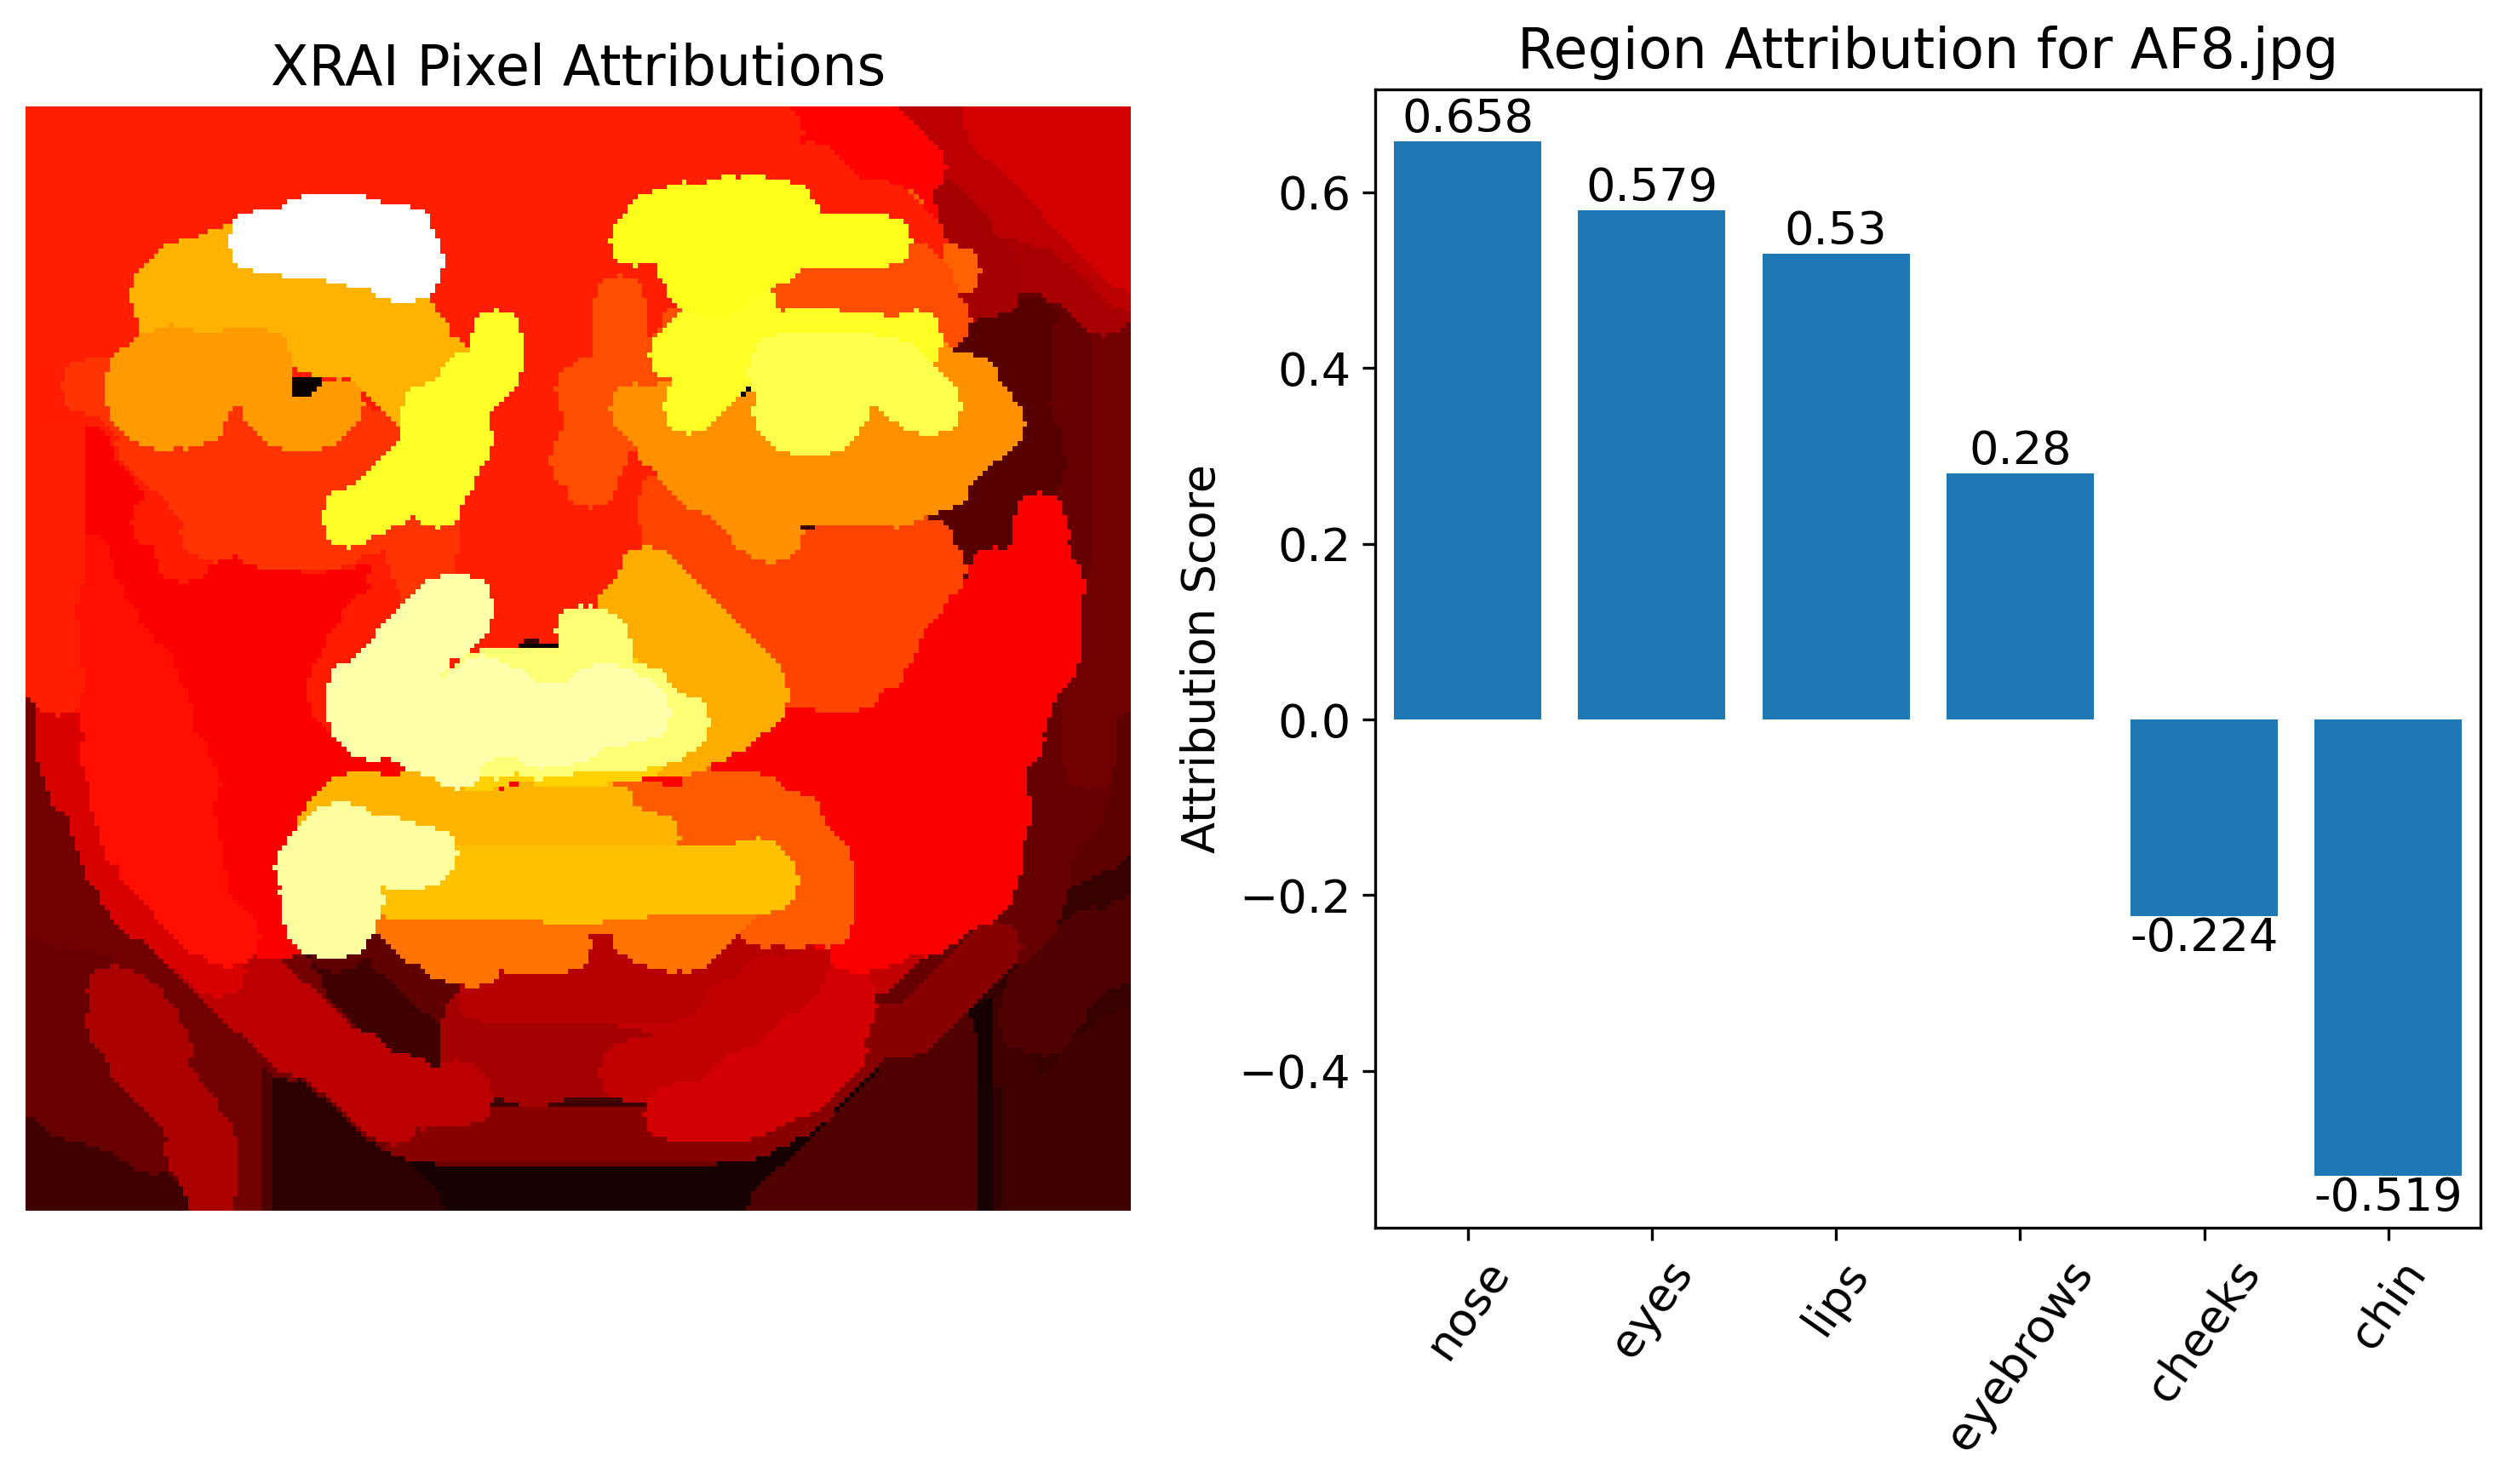

In [35]:
matplotlib.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(10, 6), dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.axis('off')
ax1.title.set_text(rf"Feature Bounding Boxes")
ax1.imshow(np.uint8(draw_boxes(os.path.join(dataset,"images",file))[...,::-1]))

p = np.abs(means-means[-1]).argsort()
ax2 = pd.Series(means[p]).plot(kind="bar")
ax2.title.set_text(rf"Invidual Feature Prediction for {file}")
ax2.set_ylabel("Beauty Score")
bars = ax2.bar(names2[p], means[p])
ax2.bar_label(bars)
ax2.set_xticklabels(names2[p], rotation=55)

plt.tight_layout()
plt.savefig(f"sfp.png")
plt.show()

fig = plt.figure(figsize=(10, 6), dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.axis('off')
ax1.title.set_text(rf"XRAI Pixel Attributions")
ax1.imshow(xrai_attributions, cmap="hot")

p = scores.argsort()[::-1]
ax2 = pd.Series(scores[p]).plot(kind="bar")
ax2.title.set_text(rf"Region Attribution for {file}")
ax2.set_ylabel("Attribution Score")
bars = ax2.bar(np.array(names), scores[p])
ax2.bar_label(bars)
ax2.set_xticklabels(np.array(names)[p], rotation=55)

plt.tight_layout()
plt.savefig(f"xrai.png")
plt.show()

(array([  281.,  7198.,  4063.,  3477.,  2051.,  1738.,  2916., 17808.,
         2629.,  1535.,  1032.,  2467.,    76.,   417.,  2488.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <BarContainer object of 15 artists>)

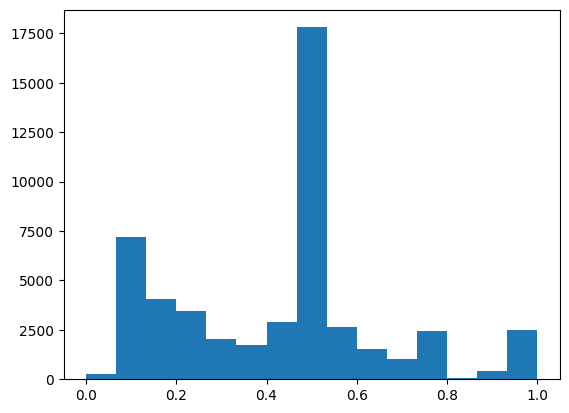

In [66]:
plt.hist(normalised.flatten(), bins=15)